В качестве домашнего задания вам предлагается поработать над предсказанием погоды. Файл с данными вы найдете в соответствующей директории. Вам будет доступен датасет weather.csv, ПЕРВЫЕ 75% (shuffle = False) которого нужно взять для обучения, последние 25% - для тестирования.

Требуется построить 4 модели которые будут предсказывать целевую переменную <b>RainTomorrow</b> с помощью:

   1. логистической регрессии [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
   
   2. метода ближайших соседей [sklearn.neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
 
   3. Байесовского классификатора [sklearn.naive_bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
   
   4. логистической регрессии реализованной самостоятельно

Затем следует сравнить результаты моделей (по качеству и времени выполнения) и сделать вывод о том, какая модель и с какими параметрами даёт лучшие результаты.

Не забывайте о том, что работа с признаками играет очень большую роль в построении хорошей модели.

Краткое описание данных:

    Date - Дата наблюдений
    Location - Название локации, в которой расположена метеорологическая станция
    MinTemp - Минимальная температура в градусах цельсия
    MaxTemp - Максимальная температура в градусах цельсия
    Rainfall - Количество осадков, зафиксированных за день в мм
    Evaporation - Так называемое "pan evaporation" класса А (мм) за 24 часа до 9 утра
    Sunshine - Число солнечных часов за день
    WindGustDir - направление самого сильного порыва ветра за последние 24 часа
    WindGustSpeed - скорость (км / ч) самого сильного порыва ветра за последние 24 часа
    WindDir9am - направление ветра в 9 утра

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

%matplotlib inline
#%matplotlib notebook

### Реализация логистической регрессии
__Логистическая регрессия__

$$p(y|x) = a(x, \theta) = \sigma(\langle x, \theta \rangle) = \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}$$

In [2]:
theta = np.array([1, 2, 3])

X =  np.array([[ 1,  1, 1],
               [-1, -2, 1],
               [-1, -2, 2],
               [-2, -2, -3]
              ])

y = np.array([1, 1, 0, 0])

In [3]:
def probability(theta, X):
    result = 1/(np.ones(X.shape[0]) + np.exp(-np.dot(X,theta)))
    return result
prob = probability(theta, X)


assert type(prob) == np.ndarray, 'Возвращается неверный тип'
assert prob.shape == (X.shape[0],), 'Неверный размер массива'
assert (prob.round(3) == [0.998, 0.119, 0.731, 0.]).all(), 'Функция считается неверно'

Функция предсказания метки класса, получает на вход вероятности принадлежности к классу 1 и выдает метки классов $y \in \{0, 1\}$

In [4]:
result = np.array(list(map(lambda x: 0 if x < 0.5 else 1,prob)))

In [5]:
fill = np.vectorize(lambda x: 0 if x < 0.5 else 1)
fill(prob)

array([1, 0, 1, 0])

In [6]:
result

array([1, 0, 1, 0])

In [7]:
def binary_class_prediction(theta, X, threshold =0.5):
    prob =  probability(theta, X)
    fill = np.vectorize(lambda x: 0 if x < threshold else 1)
    return fill(prob)
y_pred = binary_class_prediction(theta, X)


assert type(y_pred) == np.ndarray, 'Возвращается неверный тип'
assert y_pred.shape == (X.shape[0],), 'Неверный размер массива'
assert min(y_pred) == 0, 'Функция считается неверно'
assert max(y_pred) == 1, 'Функция считается неверно'

__Функционал качества логистической регрессии__

Запишем правдободовие выборки для меток класса $y \in \{+1, -1\}$ 

$$Likelihood(a, X^\ell) = \prod_{i = 1}^{\ell} a(x_i,\theta)^{[y_i = +1]} (1 - a(x_i, \theta))^{[y_i = -1]} → \operatorname*{max}_{\theta}$$ 

Прологарифмируем правдоподобие выборки и перейдем к задаче минимизации:

$$Q(a, X^\ell) =     -\sum_{i = 1}^{\ell} 
        [y_i = +1] \log a(x_i, \theta)
        +
        [y_i = -1] \log (1 - a(x_i, \theta)) \to \operatorname*{min}_{\theta}$$ 
        
Подставим $a(x, \theta)$ в функцинал качества:

$$ Q(a, X^\ell) = -\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{\exp(-\langle \theta, x_i \rangle)}{1 + \exp(-\langle \theta, x_i \rangle)}
\right)
=\\
=
-\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{1}{1 + \exp(\langle \theta, x_i \rangle)}
\right)
=\\
=
\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) $$
    

Итоговый оптимизируемый функционал качества (logloss), записанный для меток классов $y \in \{+1, -1\}$ и усредненный по выборке

$$Q(a, X^\ell) = \frac{1}{\ell}\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) \to \operatorname*{min}_{\theta}$$

Реализуем его в функции logloss:

In [8]:
def logloss(theta, X, y): 
    l = X.shape[0]
    y_changed = y.copy()
    y_changed[y == 0] = -1
    result = np.sum(np.log(np.ones(l) + np.exp(-y_changed*np.dot(X,theta))))
    return result/l

In [9]:
assert logloss(theta, X, y).round(3) == 0.861, 'Функция считается неверно'

__Алгоритм оптимизации функционала качества. Стохастический градиентный спуск__

<b>Вход: </b> Выборка $X^\ell$, темп обучения $h$

<b>Выход: </b> оптимальный вектор весов $\theta$

1.  Инициализировать веса $\theta$
2.  Инициализировать оценку функционала качества: $Q(a, X^\ell)$
3.  <b>Повторять</b>: 

    Выбрать случайным образом подвыборку объектов $X^{batch} =\{x_1, \dots,x_n \}$ из $X^{\ell}$
    
    Рассчитать градиент функционала качества: $\nabla Q(X^{batch}, \theta)$
    
    Обновить веса: $\theta := \theta - h\cdot \nabla Q(X^{batch}, \theta)$
       
    <b>Пока</b> значение $Q$ и/или веса $\theta$ не сойдутся   

Реализуем функцию рассчета градиента функционала качества

$$\frac{\partial Q(a, X^{batch}) }{\partial \theta_j}   = \frac{\partial \frac{1}{n}\sum_{i = 1}^{n}
    \log \left(
        1 + \exp(- y_i \langle \theta, x_i \rangle)
    \right)} {\partial \theta_j}  = \frac{1}{n}\sum_{i = 1}^{n}
     \frac {1}{
        1 + \exp(- y_i \langle \theta, x_i \rangle)} \cdot  \exp(- y_i \langle \theta, x_i \rangle) \cdot -y_i x_{ij}$$

Реализуйте рассчет градиента в матричном виде:

In [10]:
def gradient(theta, X, y):
    def th_i(theta,X,y,j):
        l = X.shape[0]
        y_changed = y.copy()
        y_changed[y == 0] = -1
        first_factor = 1/(np.ones(l) + np.exp(-y_changed*np.dot(X,theta)))
        second_factor = np.exp(-y_changed*np.dot(X,theta))
        third_factor = -y_changed*X[:,j]
        theta_j = 1/l*np.sum(first_factor*second_factor*third_factor) 
        return theta_j
    result = np.array([th_i(theta,X,y,j) for j in range(theta.shape[0])])
    
    return result 

assert gradient(theta, X, y).shape == theta.shape, 'Неверный размер массива'

Функция обучения уже реализована

In [11]:
def fit(X, y, batch_size=10, h=0.05,  iters=100, plot=True):


    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)

    errors = []

    theta_history = theta
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]

    # plt
    if plot:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')
        fig.show()


    for _ in range(iters):

        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X[batch]
        y_batch = y[batch]

        # считаем производные
        grad = gradient(theta, X_batch, y_batch)

        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(theta), 'длина вектора должна быть равной количеству весов'


        # Обновляем веса

        theta -= grad * h

        theta_history = np.vstack((theta_history, theta))

        # error
        loss = logloss(theta, X, y)
        errors.append(loss)

        if plot:
            ax1.clear()
            ax1.scatter(range(dim), theta, label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('theta')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')


            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('logloss')
            ax2.set_xlabel('itarations')

            ax3.plot(theta_history)
            ax3.set_title('update theta')
            ax3.set_ylabel('value')
            ax3.set_xlabel('itarations')
            time.sleep(0.05)
            fig.canvas.draw()
            
    return theta

In [12]:
X, y = make_classification(n_samples=2000)

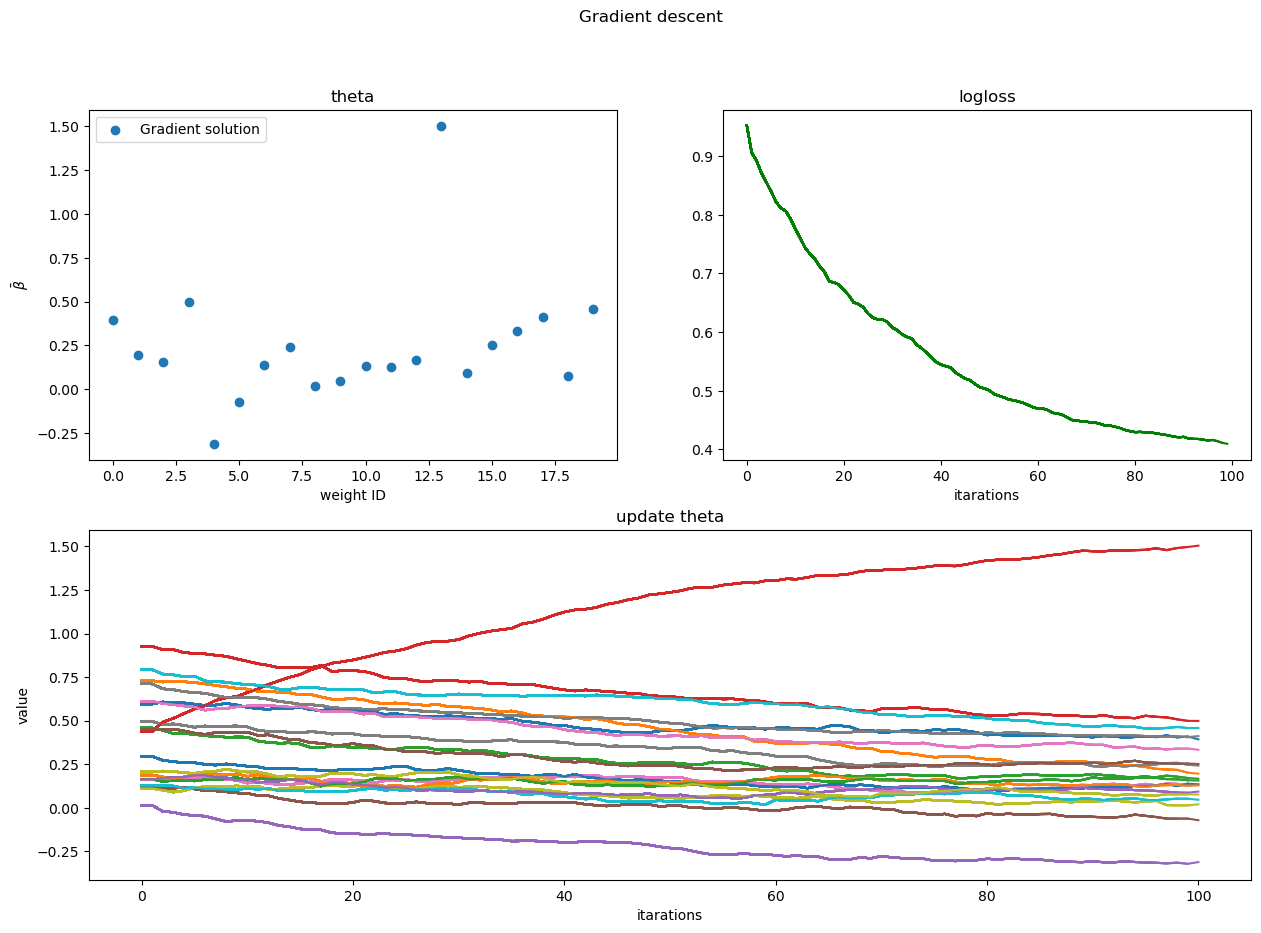

In [13]:
optimal_theta = fit(X, y)

In [14]:
y_pred = binary_class_prediction(optimal_theta, X)

In [15]:
from sklearn.metrics import classification_report,f1_score
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       997
           1       0.85      0.77      0.81      1003

    accuracy                           0.81      2000
   macro avg       0.82      0.81      0.81      2000
weighted avg       0.82      0.81      0.81      2000



для собственной реализации неплохо

 ## Предсказание погоды

In [22]:
X = pd.read_csv('weather.csv')

In [23]:
y = X.RainTomorrow.replace({'No':0, 'Yes': 1})

In [47]:
useless_columns = list()

In [48]:
useless_columns.extend(["RainTomorrow","Unnamed: 0"])


In [26]:
X = X.drop(columns=useless_columns)

# Baseline
Для начала уберем все не числовые признаки, а пропуски заполним средним.

In [27]:
from sklearn.model_selection import train_test_split

In [28]:

numeric_data = X.select_dtypes(include="number")
X_train, X_test, y_train, y_test = train_test_split(numeric_data, y, test_size=0.25, shuffle=False)
numeric_data_mean = X_train.mean()
numeric_features = X_train.columns
X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

In [29]:
from sklearn.linear_model import LogisticRegressionCV


In [30]:
model = LogisticRegressionCV()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))
print(model.C_)
print(f1_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91     27882
           1       0.78      0.39      0.52      7667

    accuracy                           0.84     35549
   macro avg       0.82      0.68      0.71     35549
weighted avg       0.84      0.84      0.82     35549

[0.00077426]
0.5208550573514077


Видно, что у модели очен низкая полнота для 1. Будем отталкиваться от f1-score = 0.5208

Воспользуемся методом с семинара

In [31]:
def show_weights(features, weights, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
    sorted_weights = sorted(zip(weights, features, scales), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    scales = [x[2] for x in sorted_weights]
    sns.barplot(y=features, x=weights, ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=scales, ax=axs[1])
    axs[1].set_xlabel("Scale")
    plt.tight_layout()

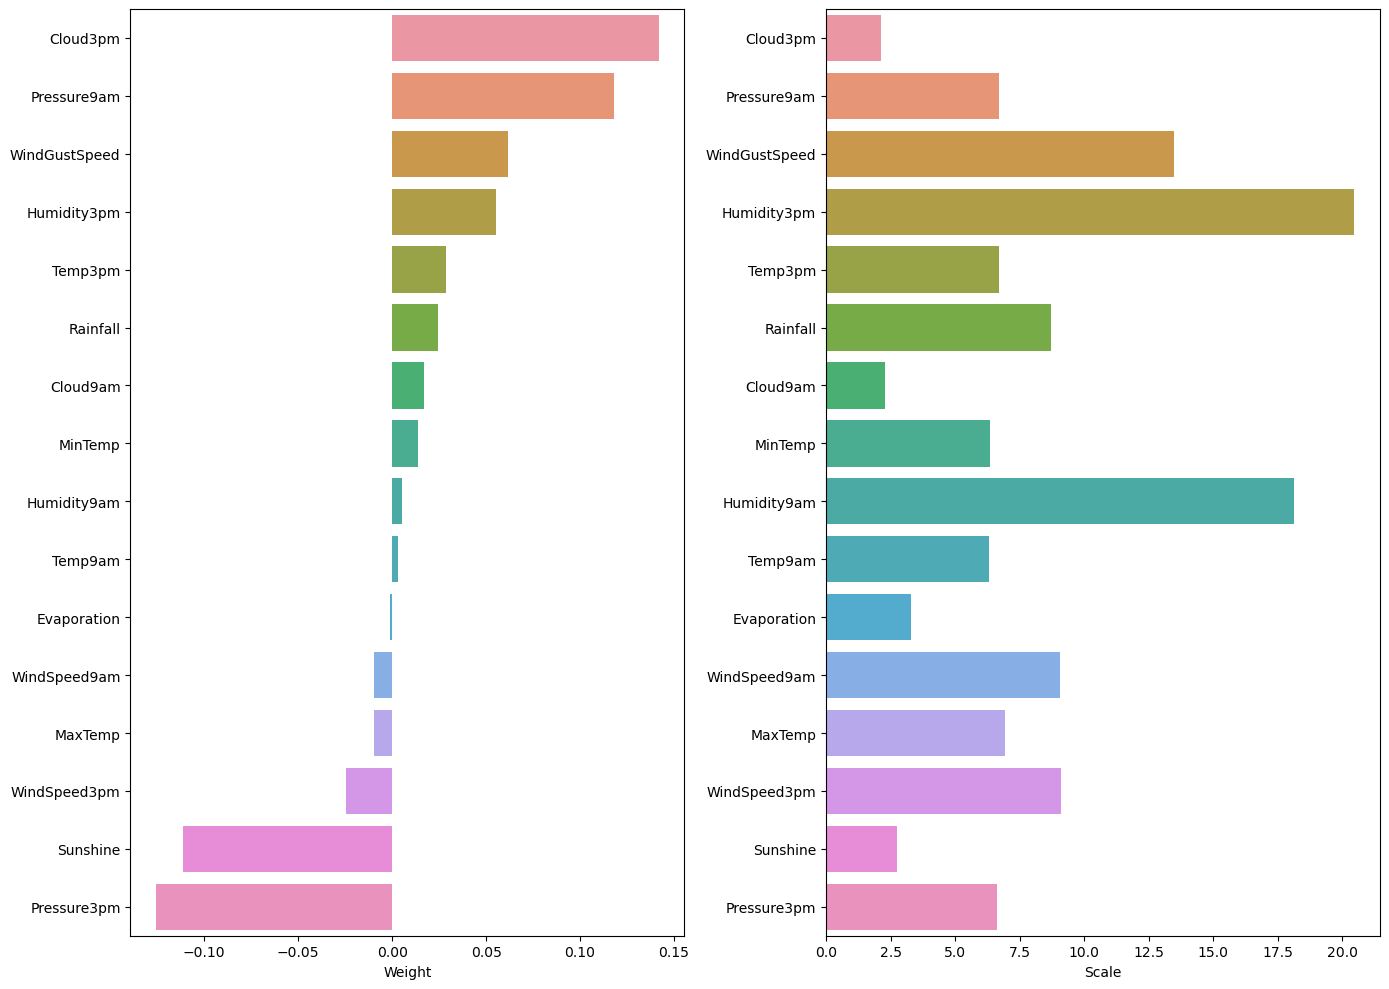

In [32]:
show_weights(numeric_features, model.coef_[0], X_train.std())


## Попробуем поработать с признаками
А именно: 
1) Не будем учитывать признаки с малыми коэффициентами.
2) попробовать сделать Ohe для даты, хотя бы для месяца, 
3) Числовые колонки масштабировать, тк линейные модели чувствительны к разному масштабу признаков.

In [43]:
X = pd.read_csv('weather.csv')

оставим только месяц от даты

In [44]:
X["Date"] = np.vectorize(lambda x: int(x[5:7]))(X["Date"])

In [45]:
from sklearn.preprocessing import OneHotEncoder
Ohe = OneHotEncoder()

In [49]:
useless_columns.extend(["Humidity9am","Temp9am","Evaporation","MaxTemp", "WindDir3pm","Date"])

In [50]:
encoder = OneHotEncoder(sparse=False)
onehot_columns = encoder.fit_transform(X[['Date']])
X = pd.concat([X, pd.DataFrame(onehot_columns)], axis=1)

In [51]:

X = X.drop(columns= useless_columns)

In [52]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       142193 non-null  object 
 1   MinTemp        141556 non-null  float64
 2   Rainfall       140787 non-null  float64
 3   Sunshine       74377 non-null   float64
 4   WindGustDir    132863 non-null  object 
 5   WindGustSpeed  132923 non-null  float64
 6   WindDir9am     132180 non-null  object 
 7   WindSpeed9am   140845 non-null  float64
 8   WindSpeed3pm   139563 non-null  float64
 9   Humidity3pm    138583 non-null  float64
 10  Pressure9am    128179 non-null  float64
 11  Pressure3pm    128212 non-null  float64
 12  Cloud9am       88536 non-null   float64
 13  Cloud3pm       85099 non-null   float64
 14  Temp3pm        139467 non-null  float64
 15  RainToday      140787 non-null  object 
 16  0              142193 non-null  float64
 17  1              142193 non-nul

In [53]:
X.columns = X.columns.astype(str)
numeric_data = X.select_dtypes(include="number")
X_train, X_test, y_train, y_test = train_test_split(numeric_data, y, test_size=0.25, shuffle=False)
numeric_data_mean = X_train.mean()
numeric_features = X_train.columns
X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)


In [54]:
model = LogisticRegressionCV()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))
print(model.C_)
print(f1_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91     27882
           1       0.78      0.39      0.52      7667

    accuracy                           0.85     35549
   macro avg       0.82      0.68      0.71     35549
weighted avg       0.84      0.85      0.82     35549

[1.e-04]
0.5207698336671601


видно, что разбиение по месяцам ничего не дало!

Дату сделаем превратим в 4 сезона

In [59]:
X = pd.read_csv('weather.csv')
X["Date"] = np.vectorize(lambda x: int(x[5:7])//3)(X["Date"])
X["Date"][X["Date"]==4] = 0

Число солнечных дней в году важный признак, но он есть всего у половины данных и просто заполнять средним будет не очень рационально.
Поэтому заполним средним числом в сезоне

In [60]:
print(X.groupby('Date')["Sunshine"].mean())

Date
0    8.950022
1    7.041726
2    6.297095
3    8.298351
Name: Sunshine, dtype: float64


вот это да, это же австралия - тут весной и летом меньше солнечных дней.

In [61]:
X["Sunshine"] = X.groupby('Date')["Sunshine"].transform(lambda x: x.fillna(x.mean()))

In [62]:
encoder = OneHotEncoder(sparse=False)
onehot_columns = encoder.fit_transform(X[['Date']])
X = pd.concat([X, pd.DataFrame(onehot_columns)], axis=1)

In [63]:
useless_columns

['RainTomorrow',
 'Unnamed: 0',
 'Humidity9am',
 'Temp9am',
 'Evaporation',
 'MaxTemp',
 'WindDir3pm',
 'Date']

In [64]:
useless_columns.extend(["Cloud9am", "WindDir9am"])

In [65]:
dict_column_names = {0: "winter",
                    1: "spring",
                    2: "summer",
                    3: "fall"}
X.rename(columns=dict_column_names,
          inplace=True)

In [66]:
X.describe(include="all")

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,winter,spring,summer,fall
count,142193.000000,142193.000000,142193,141556.000000,141871.000000,140787.000000,81350.000000,142193.000000,132863,132923.000000,...,88536.000000,85099.000000,141289.000000,139467.000000,140787,142193,142193.000000,142193.000000,142193.000000,142193.000000
unique,NaN,NaN,49,NaN,NaN,NaN,NaN,NaN,16,NaN,...,NaN,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN
top,NaN,NaN,Canberra,NaN,NaN,NaN,NaN,NaN,W,NaN,...,NaN,NaN,NaN,NaN,No,No,NaN,NaN,NaN,NaN
freq,NaN,NaN,3418,NaN,NaN,NaN,NaN,NaN,9780,NaN,...,NaN,NaN,NaN,NaN,109332,110316,NaN,NaN,NaN,NaN
mean,72884.900649,1.498576,NaN,12.186400,23.226784,2.349974,5.469824,7.619165,NaN,39.984292,...,4.437189,4.503167,16.987509,21.687235,NaN,NaN,0.240912,0.263002,0.252685,0.243402
std,42069.147355,1.103917,NaN,6.403283,7.117618,8.465173,4.188537,2.826449,NaN,13.588801,...,2.887016,2.720633,6.492838,6.937594,NaN,NaN,0.427639,0.440265,0.434553,0.429137
min,0.000000,0.000000,NaN,-8.500000,-4.800000,0.000000,0.000000,0.000000,NaN,6.000000,...,0.000000,0.000000,-7.200000,-5.400000,NaN,NaN,0.000000,0.000000,0.000000,0.000000
25%,36235.000000,1.000000,NaN,7.600000,17.900000,0.000000,2.600000,6.297095,NaN,31.000000,...,1.000000,2.000000,12.300000,16.600000,NaN,NaN,0.000000,0.000000,0.000000,0.000000
50%,73311.000000,1.000000,NaN,12.000000,22.600000,0.000000,4.800000,8.298351,NaN,39.000000,...,5.000000,5.000000,16.700000,21.100000,NaN,NaN,0.000000,0.000000,0.000000,0.000000
75%,109247.000000,2.000000,NaN,16.800000,28.200000,0.800000,7.400000,8.950022,NaN,48.000000,...,7.000000,7.000000,21.600000,26.400000,NaN,NaN,0.000000,1.000000,1.000000,0.000000


In [67]:
X["RainToday"] = X.RainToday.replace({'No':0, 'Yes': 1})

я пытался учесть города OneHotEncoding, но 49 новых фич портит результат.

In [68]:
useless_columns.append("Location")

In [69]:
X = X.drop(columns=useless_columns)

In [71]:
X.columns = X.columns.astype(str)
numeric_data = X.select_dtypes(include="number")
X_train, X_test, y_train, y_test = train_test_split(numeric_data, y, test_size=0.25, shuffle=False)
numeric_data_mean = X_train.mean()
numeric_features = X_train.columns
X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)
model = LogisticRegressionCV()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))
print("Best alpha = %.4f" %model.C_)
print(f1_score(y_test,y_pred))
best_alpha = model.C_


              precision    recall  f1-score   support

           0       0.86      0.97      0.91     27882
           1       0.78      0.41      0.53      7667

    accuracy                           0.85     35549
   macro avg       0.82      0.69      0.72     35549
weighted avg       0.84      0.85      0.83     35549

Best alpha = 0.0464
0.5343589743589743


результат уже лучше

## Попробуем сделать pipeline

In [72]:
useless_columns.pop(7)

'Date'

In [109]:
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression


X = pd.read_csv('weather.csv')
y = X.RainTomorrow.replace({'No':0, 'Yes': 1})

X["Date"] = np.vectorize(lambda x: int(x[5:7])//3)(X["Date"])
X["Sunshine"] = X.groupby('Date')["Sunshine"].transform(lambda x: x.fillna(x.mean()))

numeric_features = ['MinTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Cloud3pm', 'Temp3pm']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), ["Date"]),
    ('scaling', RobustScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegressionCV(penalty="l2",cv=10))
])
X = X.drop(columns= useless_columns)

X.columns = X.columns.astype(str)
numeric_data = X.select_dtypes(include="number")
X_train, X_test, y_train, y_test = train_test_split(numeric_data, y, test_size=0.25, shuffle=False)
numeric_data_mean = X_train.mean()
numeric_features = X_train.columns
X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)





model = pipeline.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test,y_pred))
print(f1_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     27882
           1       0.77      0.44      0.56      7667

    accuracy                           0.85     35549
   macro avg       0.81      0.70      0.73     35549
weighted avg       0.84      0.85      0.83     35549

0.5552045227801796


Попробуем применить квадраты признаков

In [81]:
from sklearn.preprocessing import PolynomialFeatures
column_transformer_poly = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), ["Date"]),
     ('poly', PolynomialFeatures(degree=2),numeric_features),
    ('scaling',StandardScaler(), numeric_features),
   
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer_poly),
    ('regression', LogisticRegressionCV(penalty="l2",cv=10))
])


model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test,y_pred))
print(f1_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91     27882
           1       0.78      0.40      0.53      7667

    accuracy                           0.85     35549
   macro avg       0.82      0.68      0.72     35549
weighted avg       0.84      0.85      0.83     35549

0.5281198863147016


Попробуем сбалансировать число данных при обучении:

К сожалению, ничего нам это не дало()

In [96]:
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('logreg_cv', LogisticRegressionCV(class_weight='balanced',penalty="l2",cv=10))
])
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test,y_pred))
print(f1_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88     27882
           1       0.56      0.74      0.64      7667

    accuracy                           0.82     35549
   macro avg       0.74      0.79      0.76     35549
weighted avg       0.84      0.82      0.83     35549

0.6353887399463807


In [100]:
logreg_cv = model.named_steps['logreg_cv']
print("Параметры LogisticRegressionCV:")
print(logreg_cv.get_params())
print("best params:")
print(logreg_cv.C_)

Параметры LogisticRegressionCV:
{'Cs': 10, 'class_weight': 'balanced', 'cv': 10, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'refit': True, 'scoring': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0}
best params:
[0.35938137]


измерим время 

In [104]:
import time
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('logreg_cv', LogisticRegression(C=0.35938137,class_weight='balanced',penalty="l2"))
])
start_time = time.time()
model = pipeline.fit(X_train, y_train)
end_time = time.time()
time_log_reg = end_time - start_time

y_pred = model.predict(X_test)

print(classification_report(y_test,y_pred))
print(f1_score(y_test,y_pred))
f1_log= f1_score(y_test,y_pred)
print(time_log_reg)

              precision    recall  f1-score   support

           0       0.92      0.84      0.88     27882
           1       0.56      0.74      0.64      7667

    accuracy                           0.82     35549
   macro avg       0.74      0.79      0.76     35549
weighted avg       0.84      0.82      0.83     35549

0.6354294649838044
0.3261711597442627


## Попробуем собственную реализацию

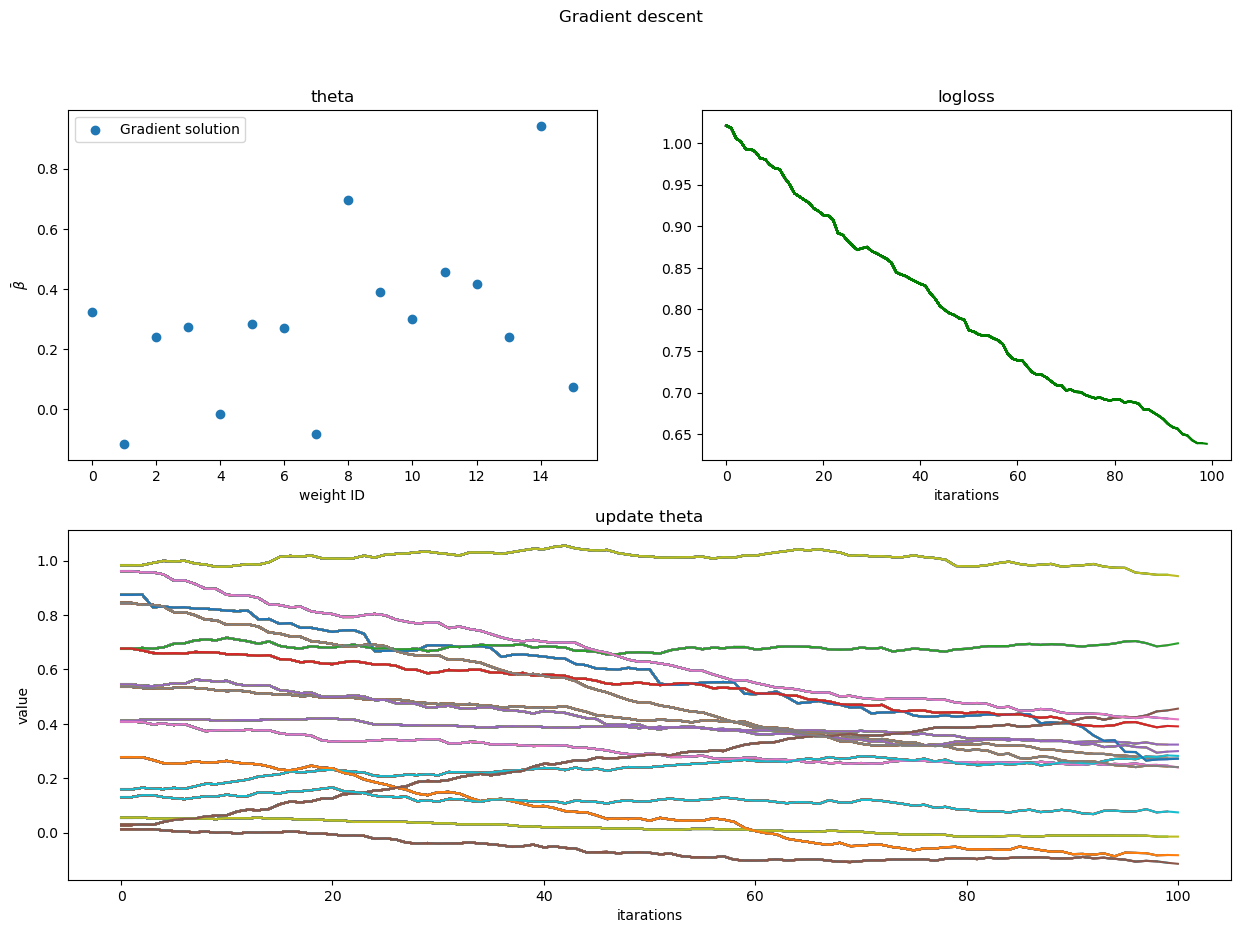

In [137]:
from imblearn.over_sampling import SMOTE
start_time = time.time()
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_train_transformed = column_transformer.fit_transform(X_resampled)
X_test_transformed = column_transformer.fit_transform(X_test)

optimal_theta = fit(X_train_transformed, y_resampled)
end_time = time.time()
time_log_reg_own = end_time - start_time

In [146]:
print(classification_report(y_test,binary_class_prediction(optimal_theta,X_test_transformed,0.8)))
print(f1_score(y_test,binary_class_prediction(optimal_theta,X_test_transformed,0.8)))
f1_log_own= f1_score(y_test,binary_class_prediction(optimal_theta,X_test_transformed,0.8))
print(time_log_reg_own)

              precision    recall  f1-score   support

           0       0.88      0.81      0.84     27882
           1       0.46      0.60      0.52      7667

    accuracy                           0.76     35549
   macro avg       0.67      0.70      0.68     35549
weighted avg       0.79      0.76      0.77     35549

0.5225615314494075
21.829694509506226


Результат 0.5137320328542094 сопоставим с библиотчным, однако очень нестабильный.

# KNN

In [112]:
from sklearn.neighbors import KNeighborsClassifier


In [115]:
pipeline_knn = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('knn', KNeighborsClassifier())
])

In [155]:
from sklearn.model_selection import GridSearchCV
neighbors = np.linspace(5, 150, 10,dtype=int)
searcher = GridSearchCV(pipeline_knn, [{'knn__n_neighbors' : neighbors}],
                        scoring='roc_auc', cv=5, n_jobs=-1)
searcher.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ohe_and_scaling',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Date']),
                                                                        ('scaling',
                                                                         RobustScaler(),
                                                                         ['MinTemp',
                                                                          'Rainfall',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Pressure3pm',
                                                                          'Cloud3pm',
                                                                          'Temp3pm'])])),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-1,
                                                             n_neighbors=100))]),
             n_jobs=-1,
             param_grid=[{'knn__n_neighbors': array([  5,  21,  37,  53,  69,  85, 101, 117, 133, 150])}],
             scoring='roc_auc')

In [150]:
print("Best parameters found: ",searcher.best_params_)

# Точность на тестовом наборе данных
best_model = searcher.best_estimator_
y_pred_knn = best_model.predict(X_test)
print(classification_report(y_test,y_pred_knn))
print(f1_score(y_test,y_pred_knn))

Best parameters found:  {'knn__n_neighbors': 100}
              precision    recall  f1-score   support

           0       0.85      0.97      0.90     27882
           1       0.77      0.36      0.49      7667

    accuracy                           0.84     35549
   macro avg       0.81      0.66      0.70     35549
weighted avg       0.83      0.84      0.81     35549

0.4869456366237482


обучим модель на всех данных

In [154]:
from imblearn.over_sampling import SMOTE

pipeline_knn = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('knn', KNeighborsClassifier(weights="uniform",algorithm= "auto",n_neighbors= 100, n_jobs=-1,))
])

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
start_time = time.time()

model = pipeline_knn.fit(X_resampled, y_resampled)

end_time = time.time()
time_knn = end_time - start_time

y_pred = model.predict(X_test)

print(classification_report(y_test,y_pred))
print(f1_score(y_test,y_pred))
f1_knn= f1_score(y_test,y_pred)
print(time_knn)

              precision    recall  f1-score   support

           0       0.92      0.82      0.87     27882
           1       0.53      0.74      0.62      7667

    accuracy                           0.80     35549
   macro avg       0.72      0.78      0.74     35549
weighted avg       0.84      0.80      0.81     35549

0.6162910112966866
0.07128381729125977


# NaiveBias

In [134]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.preprocessing import MinMaxScaler
column_transformer_NB = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), ["Date"]),
    ('scaling', RobustScaler(), numeric_features)
])
pipeline_NB= Pipeline(steps=[
    ('ohe_and_scaling', column_transformer_NB),
    ('NB', GaussianNB(var_smoothing = 0.001))
])

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
start_time = time.time()

pipeline_NB.fit(X_resampled, y_resampled )

end_time = time.time()
time_nb = end_time - start_time



In [135]:
y_pred_NB = pipeline_NB.predict(X_test)
print(classification_report(y_test,y_pred_NB))
print(f1_score(y_test,y_pred_NB))
f1_NB= f1_score(y_test,y_pred_NB)
print(time_nb)

              precision    recall  f1-score   support

           0       0.89      0.88      0.89     27882
           1       0.59      0.62      0.61      7667

    accuracy                           0.83     35549
   macro avg       0.74      0.75      0.75     35549
weighted avg       0.83      0.83      0.83     35549

0.6054685021886698
0.1058499813079834


In [136]:

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.preprocessing import MinMaxScaler,StandardScaler

column_transformer_NB = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), ["Date"]),
    ('scaling', MinMaxScaler(), numeric_features)

])

pipeline_NB= Pipeline(steps=[
    ('ohe_and_scaling', column_transformer_NB),
    ('NB',MultinomialNB(alpha= 0.1))
])
alpha = [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]
pipeline_NB.fit(X_train, y_train)
y_pred_NB = pipeline_NB.predict(X_test)
print(classification_report(y_test,y_pred_NB))
print(f1_score(y_test,y_pred_NB))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     27882
           1       1.00      0.00      0.00      7667

    accuracy                           0.78     35549
   macro avg       0.89      0.50      0.44     35549
weighted avg       0.83      0.78      0.69     35549

0.00026082420448617625


скорее всего такой низкий результат обусловлен неправильной работой с температурой. 

# Выводы

In [ ]:
print(f"LogisticRegression result = {f1_log}, time = {time_knn}")
print(f"LogisticRegressionOwn result = {f1_log_own}, time = {time_log_reg_own}")
print(f"knn result = {f1_knn}, time = {time_knn}")
print(f"GausianNB result = {f1_NB}, time = {time_nb}")

## Что помогло улучшить результаты моделей
1) Для всех моделей - баланс классов, либо собственный, либо генерация новых примеров с помощью SMOTE

2) Для  LogReg поиском по сетке был найден лучший коэф регуляризации : 0.35938137

3) Для knn оптимальным числом соседей оказалось 100

4) Для naiveBias multinominal оказался плох- для него подходит лишь minMax, и видимо этот способ абсолютно теряет всю информативность данных

5) GaussianNB не сильно зависит от коэффициента сглаживания- колебания оценки в районе 1 процента.